In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [28]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [27]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010

[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0] 8

In [26]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(X, Y)

[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0.,

In [6]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = self.transform_linears[i](x[:,0,:,:].transpose(1,2))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# One Layer

In [11]:
Trainscale = 10
sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=50, kernel_width=15, dilation=3,
           dropout=None, batch_norm=None)
layer_params = [sp1]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,Trainscale)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

Total Weights: 5543
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=500.0, buff_max=1000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 50, kernel_size=(1, 15), stride=(1, 1), dilation=(1, 3), bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, ceil_mode=False)
      )
      (act_func): ReLU()
    )
  )
  (to_out): Linear(in_features=50, out_features=43, bias=True)
)


In [15]:
model.eval()
evald = []
for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/len(perfs)])

1 0.7906976744186046
2 0.9069767441860465
3 0.9302325581395349
4 0.9302325581395349
5 0.9302325581395349
6 0.9302325581395349
7 0.9302325581395349
8 0.9069767441860465
9 0.9069767441860465
10 0.9767441860465116
11 0.9069767441860465
12 0.9069767441860465
13 0.8372093023255814
14 0.7209302325581395
15 0.7209302325581395
16 0.627906976744186
17 0.6046511627906976
18 0.5348837209302325
19 0.4418604651162791


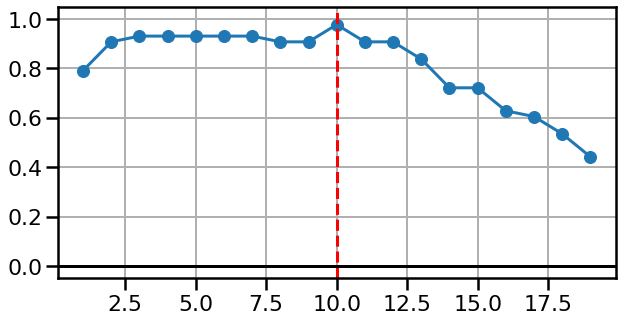

In [16]:
fig=plt.figure(figsize=(10,5))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()

# Two Layers

In [188]:

sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=15, dilation=3,
           dropout=None, batch_norm=None)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=15, dilation=3, 
           dropout=None, batch_norm=None)
layer_params = [sp1, sp2]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,10)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

KeyboardInterrupt: 

In [189]:
model.eval()
evald = []
for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/len(perfs)])

1 0.09302325581395349
2 0.2558139534883721
3 0.46511627906976744
4 0.6046511627906976
5 0.7209302325581395
6 0.9069767441860465
7 0.9767441860465116
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 0.9302325581395349
17 0.9069767441860465
18 0.8604651162790697
19 0.8372093023255814


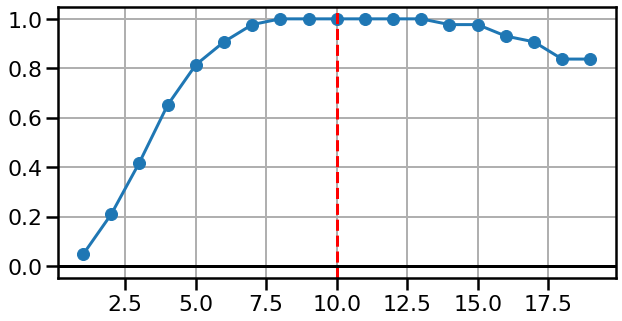

In [185]:
fig=plt.figure(figsize=(10,5))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()

# Core Idea:

SITH produces a scale invariant representation of a signal. $\tilde{f(x(t))}$ is identical if you scale $x$ across the time domain, stretching or shortening the signal. 

So, we need to identfy features in ftilde and pass them along to be used elsewhere. 

Currently, we apply a convolution as an identification mechanism. It allows us to have a "filter kernel" convolved with the $\tilde{f}$. The output of this conv, like the output of a scaled $\tilde{f}$, would be shifted in taustar space. We currently take that conv output and put a max pool on it. 

OUR THEORY: This layer layout SHOULD:

- Identify important features of the $\tilde{f}$ curve and maximally activate at that point

Important feature of a Conv->Maxpool setup:

- Maxpool makes it so only the move positve values get passed forward.  

# View First SITHCon

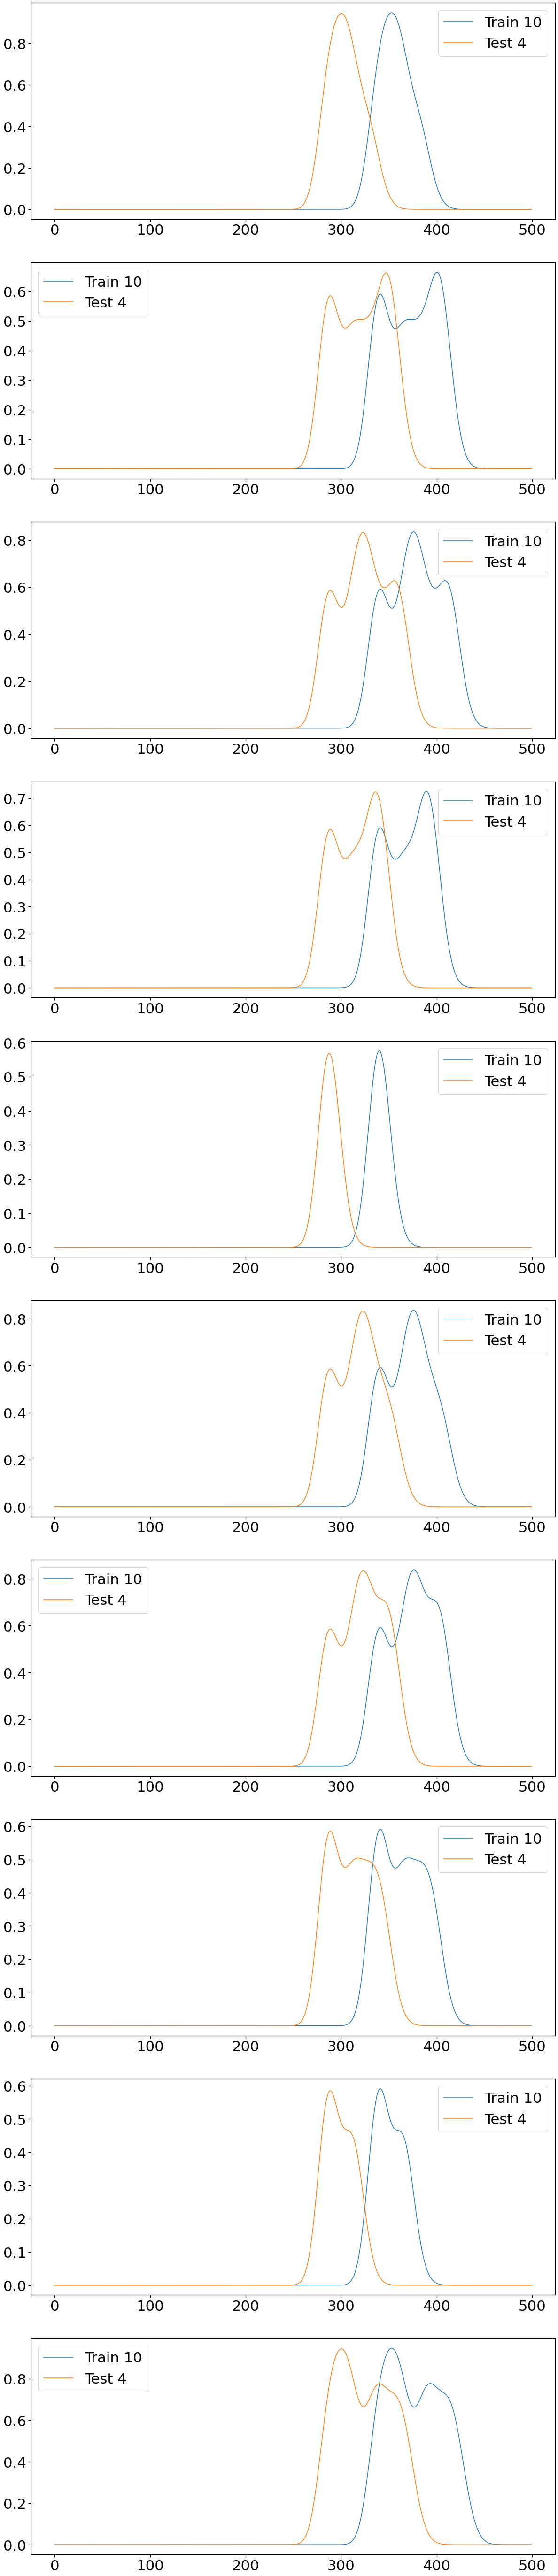

In [186]:
linew = 4
Trainscale = 10
Testscale = 4
view_channel = 2
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,100), )
    spec = gridspec.GridSpec(nrows=10, ncols=1,
                             figure=fig)
    for i in range(10):
        ax = fig.add_subplot(spec[i])
        inp = X[i].unsqueeze(0).unsqueeze(0).unsqueeze(0)
        inp = inp.unsqueeze(-1)
        inp = inp.repeat(1,1,1,1,Trainscale)
        inp = inp.reshape(1,1,1,-1)
        sout1 = model.sithcon_layers[0].sithcon.sith(inp)
        #sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        ax.plot(sout1[0, :, 0, -1].detach().cpu());
        
        inp = X[i].unsqueeze(0).unsqueeze(0).unsqueeze(0)
        inp = inp.unsqueeze(-1)
        inp = inp.repeat(1,1,1,1,Testscale)
        inp = inp.reshape(1,1,1,-1)
        sout1 = model.sithcon_layers[0].sithcon.sith(inp)

        #sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        ax.plot(sout1[0, :, 0, -1].detach().cpu());
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])

torch.Size([1, 1, 1, 140])


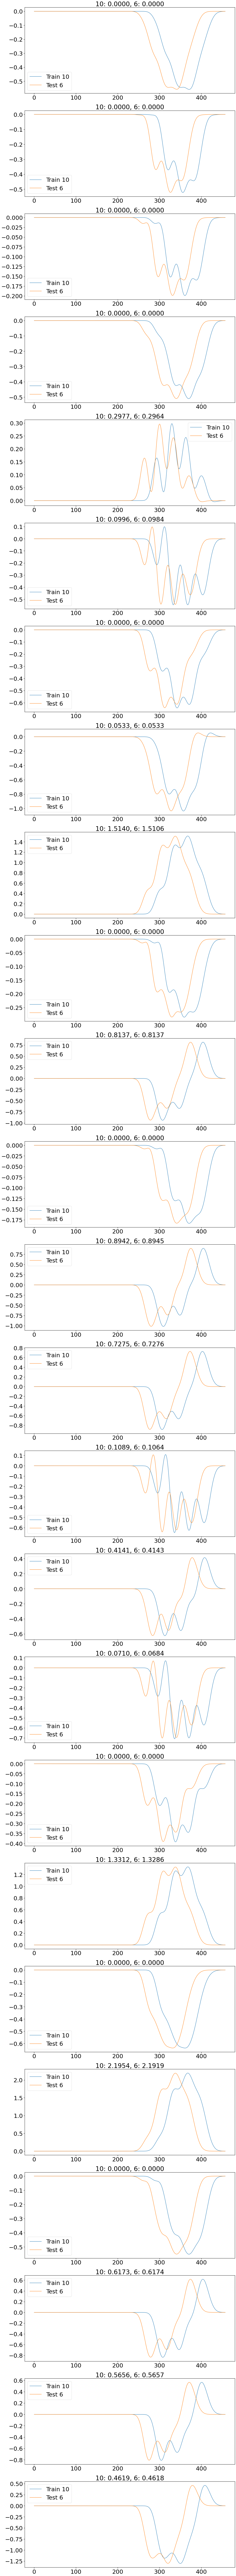

In [161]:
linew = 4
view_channel = 4
view_times = [-1, -1]
view_letter = 15
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,250), )
    spec = gridspec.GridSpec(nrows=25, ncols=1,
                             figure=fig)
    
    
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Trainscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout1 = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
        
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Testscale)
    inp = inp.reshape(1,1,1,-1)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout2 = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))

    for c in range(25):
        ax = fig.add_subplot(spec[c, 0])
        ax.plot(scout1[view_times[0], c, 0, :].detach().cpu().T);
        
        ax.plot(scout2[view_times[1], c, 0, :].detach().cpu().T);
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])
        ax.set_title("{}: {:.4f}, {}: {:.4f}".format(Trainscale, scout1[view_times[0], c, 0, :].detach().cpu().T.max(),
                                                     Testscale, scout2[view_times[1], c, 0, :].detach().cpu().T.max()))


torch.Size([1, 1, 1, 140])
torch.Size([1, 1, 1, 56])


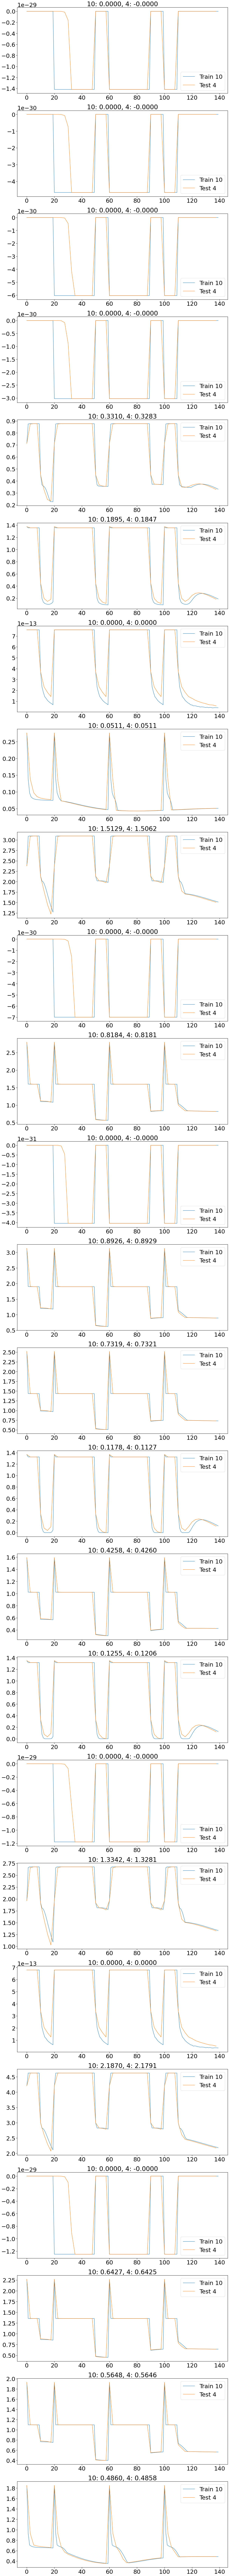

In [187]:
linew = 4
view_channel = 4
view_times = [-1, -1]
view_letter = 15
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,250), )
    spec = gridspec.GridSpec(nrows=25, ncols=1,
                             figure=fig)
    
    
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Trainscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout1 = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
        
    inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
    inp = inp.unsqueeze(-1)
    inp = inp.repeat(1,1,1,1,Testscale)
    inp = inp.reshape(1,1,1,-1)
    print(inp.shape)
    out = model.sithcon_layers[0].sithcon.sith(inp)
    out = out.transpose(3,1)
    scout2 = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))

    for c in range(25):
        ax = fig.add_subplot(spec[c, 0])
        ax.plot(np.arange(0, scout1.shape[0]), scout1[:, c, 0, :].detach().cpu().T.max(0)[0]);
        
        ax.plot(np.arange(0, scout1.shape[0], (Trainscale/Testscale)), scout2[:, c, 0, :].detach().cpu().T.max(0)[0]);
        ax.legend(["Train {}".format(Trainscale), "Test {}".format(Testscale)])
        ax.set_title("{}: {:.4f}, {}: {:.4f}".format(Trainscale, scout1[view_times[0], c, 0, :].detach().cpu().T.max(),
                                                     Testscale, scout2[view_times[1], c, 0, :].detach().cpu().T.max()))


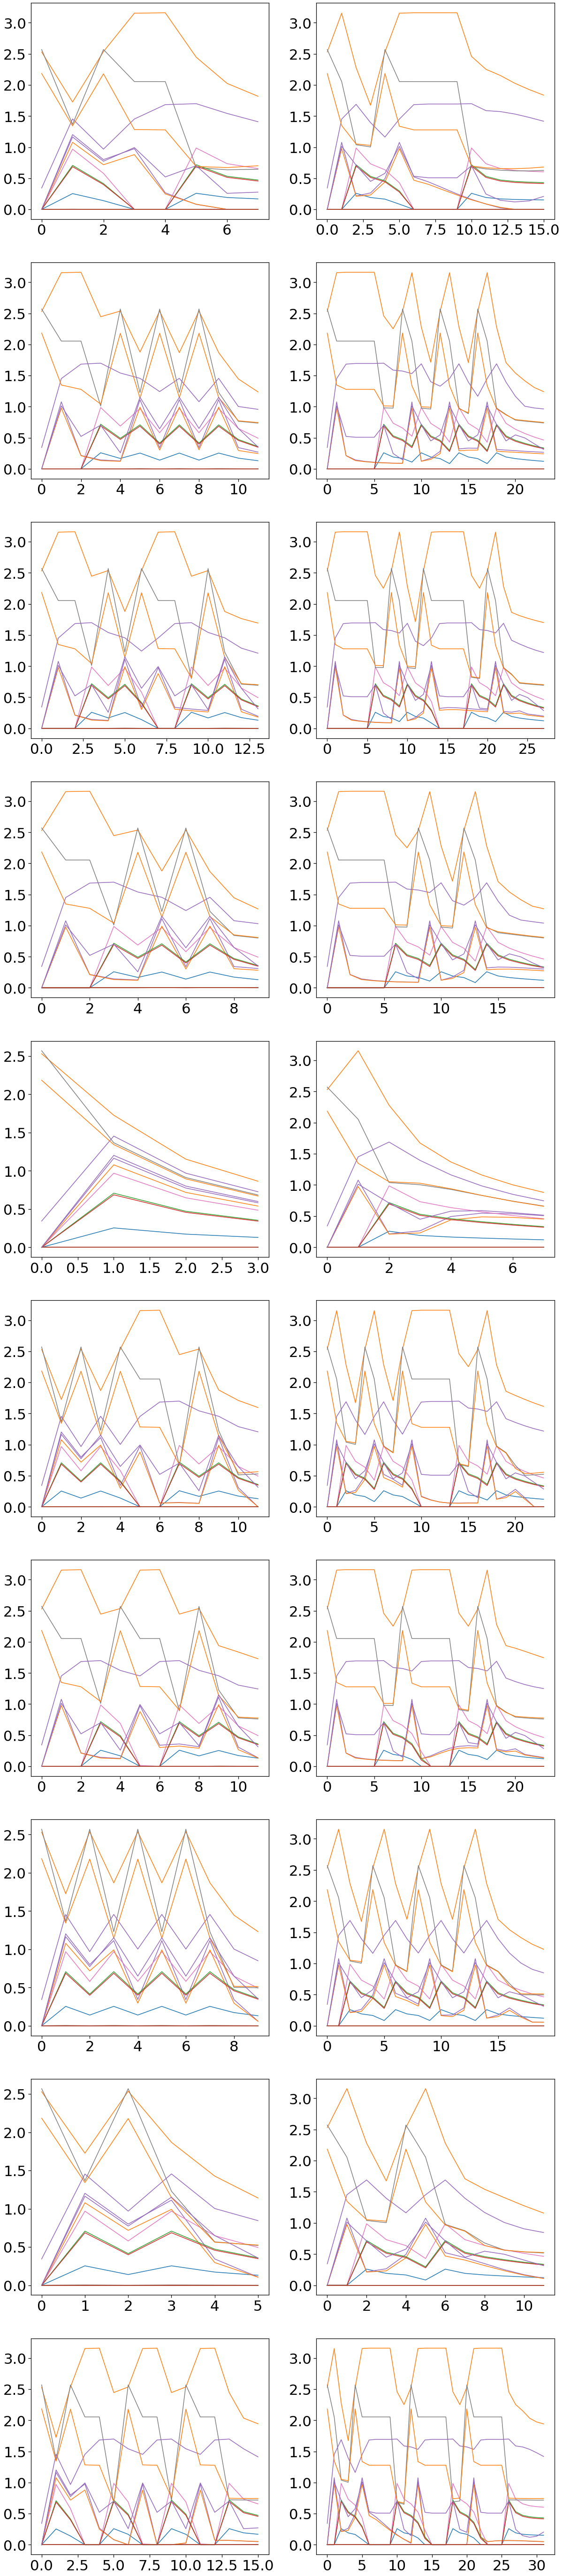

In [110]:
linew = 4
view_channel = 2
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,100), )
    spec = gridspec.GridSpec(nrows=10, ncols=2,
                             figure=fig)
    for i in range(10):
        ax = fig.add_subplot(spec[i, 0])
        inp = X[i].unsqueeze(0).unsqueeze(0).unsqueeze(0)
        scout1 = model.sithcon_layers[0](inp)
        #sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        #ax.imshow(scout1[0, 0, :, :].detach().cpu());
        ax.plot(scout1[0, 0, :, :].detach().cpu().T);

        ax = fig.add_subplot(spec[i, 1])
        inp = inp.unsqueeze(-1)
        inp = inp.repeat(1,1,1,1,2)
        inp = inp.reshape(1,1,1,-1)
        scout1 = model.sithcon_layers[0](inp)

        #sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        #ax.imshow(scout1[0, 0, :, :].detach().cpu());
        ax.plot(scout1[0, 0, :, :].detach().cpu().T);

# View Second SITH

torch.Size([1, 300, 25, 16])
torch.Size([1, 300, 25, 24])
torch.Size([1, 300, 25, 28])
torch.Size([1, 300, 25, 20])
torch.Size([1, 300, 25, 8])
torch.Size([1, 300, 25, 24])
torch.Size([1, 300, 25, 24])
torch.Size([1, 300, 25, 20])
torch.Size([1, 300, 25, 12])
torch.Size([1, 300, 25, 32])


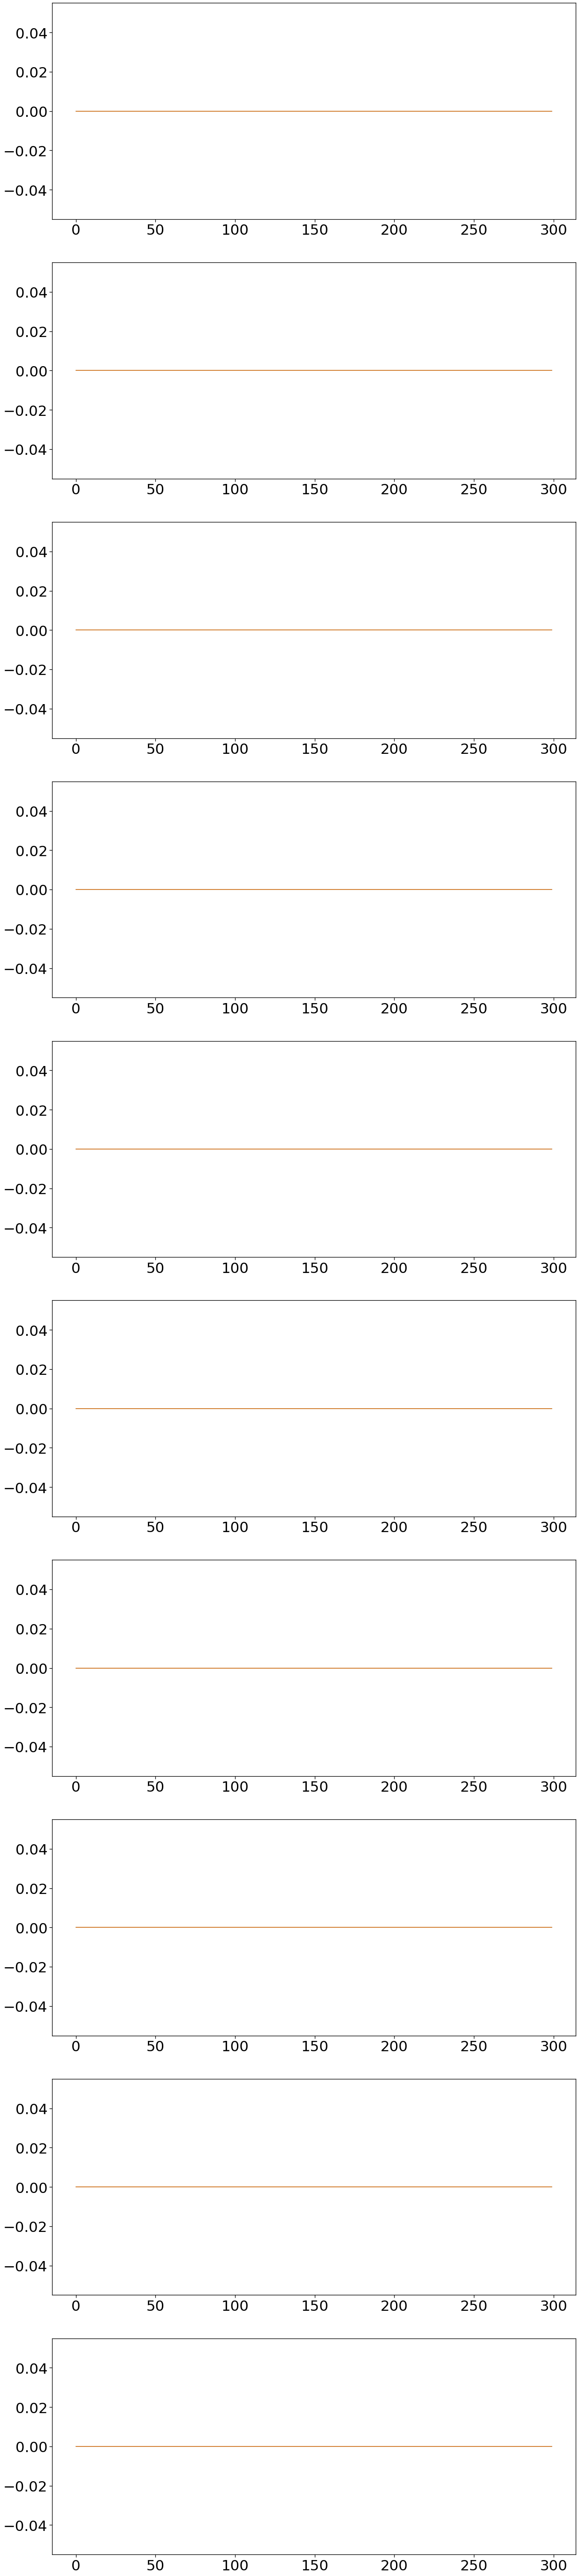

In [111]:
linew = 4
view_channel = 2
with sn.plotting_context("notebook", font_scale=2.8):
    fig = plt.figure(figsize=(20,100), )
    spec = gridspec.GridSpec(nrows=10, ncols=1,
                             figure=fig)
    for i in range(10):
        ax = fig.add_subplot(spec[i])
        inp = X[i].unsqueeze(0).unsqueeze(0).unsqueeze(0)
        sout1 = model.sithcon_layers[0].sithcon.sith(inp)
        sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        ax.plot(sout2[0, :, view_channel, -1].detach().cpu());

        inp = inp.unsqueeze(-1)
        inp = inp.repeat(1,1,1,1,2)
        inp = inp.reshape(1,1,1,-1)
        sout2 = model.sithcon_layers[1].sithcon.sith(model.sithcon_layers[0](inp))
        print(sout2.shape)
        ax.plot(sout2[0, :, view_channel, -1].detach().cpu());


# Three Layers

In [18]:

sp1 = dict(in_features=1, 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=15, dilation=3,
           dropout=None, batch_norm=None)
sp2 = dict(in_features=sp1['channels'], 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=15, dilation=3, 
           dropout=None, batch_norm=None)
sp3 = dict(in_features=sp2['channels'], 
           tau_min=.1, tau_max=500.0, buff_max=1000,
           dt=1, ntau=500, k=30, g=0.0, ttype=ttype, 
           channels=25, kernel_width=15, dilation=3, 
           dropout=None, batch_norm=None)
layer_params = [sp1, sp2, sp3]

model = SITHCon_Classifier(len(X), layer_params, act_func=nn.ReLU).cuda()
model
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,10)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

Total Weights: 22268
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=25, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=500.0, buff_max=1000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(1, 15), stride=(1, 1), dilation=(1, 3), bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, ceil_mode=False)
      )
      (act_func): ReLU()
    )
    (1): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=500, tau_min=0.1, tau_max=500.0, buff_max=1000, dt=1, k=30, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(25, 15), stride=(1, 1), dilation=(1, 3), bias=False)
        (maxp): MaxPool1d(kernel_size=458, stride=458, padding=0, dilation=1, ceil_

KeyboardInterrupt: 

In [19]:
model.eval()
evald = []
for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/len(perfs)])

1 0.13953488372093023
2 0.3023255813953488
3 0.627906976744186
4 0.8372093023255814
5 0.9302325581395349
6 0.9534883720930233
7 0.9767441860465116
8 0.9767441860465116
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 0.9767441860465116
16 0.9767441860465116
17 0.9767441860465116
18 0.9767441860465116
19 0.9302325581395349


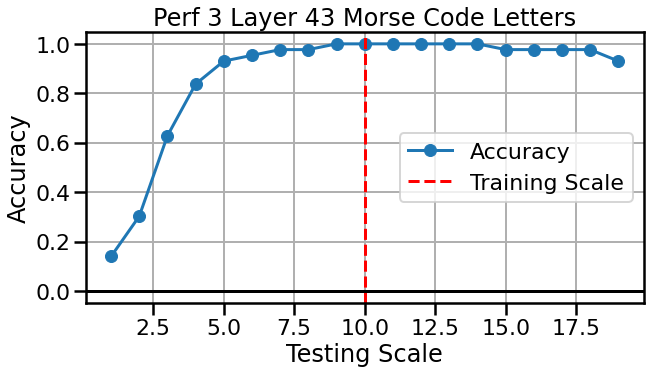

In [24]:
fig=plt.figure(figsize=(10,5))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()
plt.title('Perf 3 Layer 43 Morse Code Letters')
plt.ylabel('Accuracy')
plt.xlabel('Testing Scale')
plt.legend(['Accuracy', 'Training Scale'])

In [30]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = args[2]
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

In [ ]:
ntau = 250
k_0 = 20
tau_min = .1
tau_max = 1000.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)

k = int(res.x)
fig = plt.figure(figsize=(12,8))

print('ntau:', ntau, 'k:', k)

(-5.0, 3000.0)

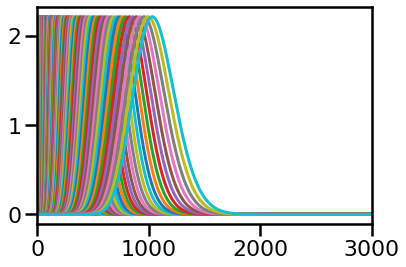

In [40]:
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, 
           k=30, ntau=ntau, dt=1.0, g=1.0)
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
#        linewidth=8, color='grey');
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
#        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
#plt.ylim(-.05, 2.1)
plt.xlim(-5, 3*tau_max)
#plt.legend(["Total Sum", "Alternating Sum"])